# Bank Predictioins

# Step 2: Discover

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

## Obtaining the Data

In [2]:
import sys

sys.path.insert(0, '/scripts/')
from scripts.helpers import load_data, find_outliers, classifier_categorical_variance

In [3]:
path = './raw_data/'
file = 'bank-full.csv'
bank_data = load_data(path=path, file=file, verbose=True, sep=';')

--------------------------------bank-full shape---------------------------------
                                  (41188, 21)                                   


----------------------------bank-full's column types----------------------------
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


---------------------------bank-full first five rows----------------------------
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic

## Cleaning the Data

There is an incredibly small probability that any rows which are exactly the same represent two distinct clients, so I will be dropping any duplicated rows.

In [4]:
bank_data.drop_duplicates(inplace=True)
bank_data.shape

(41176, 21)

In [5]:
bank_data.dropna(inplace=True)
bank_data.shape

(41176, 21)

In [6]:
bank_data.drop('duration', axis=1, inplace=True)
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Please refer to my discussion [here](./01_Define.ipynb#Dropping-'duration') for an explanation as to why I am dropping the column "duration." 

## Exploring the Data

The first thing I want to do is to compare the counts of whether a client subscribed or not to a term deposit. This is to make sure that both subscribed and not subscribed will be equally represented in the model.

Rejection rate: 0.887%
Subscription rate: 0.113%
Number of Subscribers: 4639
Number of Rejections: 36537


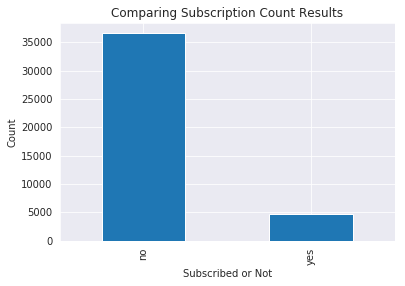

In [11]:
target_col = bank_data['y']
count = target_col.value_counts()

sns.set_style("darkgrid")
ax = count.plot(kind='bar')
ax.set_ylabel("Count")
ax.set_xlabel("Subscribed or Not")
ax.set_title("Comparing Subscription Count Results")



print(f'Rejection rate: {count["no"] / count.sum():.3f}%')
print(f'Subscription rate: {count["yes"] / count.sum():.3f}%')
print(f'Number of Subscribers: {count["yes"]}')
print(f'Number of Rejections: {count["no"]}')

As expected for a marketing campaign, the number of rejections clearly outweigh the number of people who subscribed to a term deposit with roughly 89% of the data being rejections. To get a more accurate model, it would be best to make it so that both the positive and negative results are roughly equivalent. I can achieve this by either downsampling the rejections or upsampling the subscriptions. I will be upsampling the subscriptions because there would be too large of a loss of information if I took a random sample of the rejections. The method I will be using to upsample the data is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE), and it will be applied to the training data after it has been preprocessed and split into training and validation data in the next notebook.

### Exploring the Data, Categorical Features

In [8]:
cat_cols = [x for x in bank_data.columns if bank_data[x].dtype==object and x != 'y']

counts = bank_data.groupby('month')['y'].value_counts()
total_counts = counts.groupby('month').sum()
scaled_counts = counts / total_counts

scaled_counts.xs('yes', level='y').sort_values().var()

0.03592732240724824

In [9]:
cat_variances = classifier_categorical_variance(bank_data, cat_cols, 'y')
cat_variances

,no,yes
poutcome,0.0964304,0.0964304
month,0.0359273,0.0359273
job,0.00542325,0.00542325
contact,0.00451867,0.00451867
default,0.0042027,0.00298509
education,0.00213338,0.00213338
marital,0.00062314,0.00062314
day_of_week,7.72104e-05,7.72104e-05
housing,2.03453e-05,2.03453e-05
loan,7.79057e-06,7.79057e-06


As we can see, there is a greater variety in outcome rate for variables *poutcome* and *month* whereas features *day_of_week*, *housing*, and *loan* don't vary much at all. The variables with low variance will be quite useless when doing the analysis and can be safely removed from the dataset. 

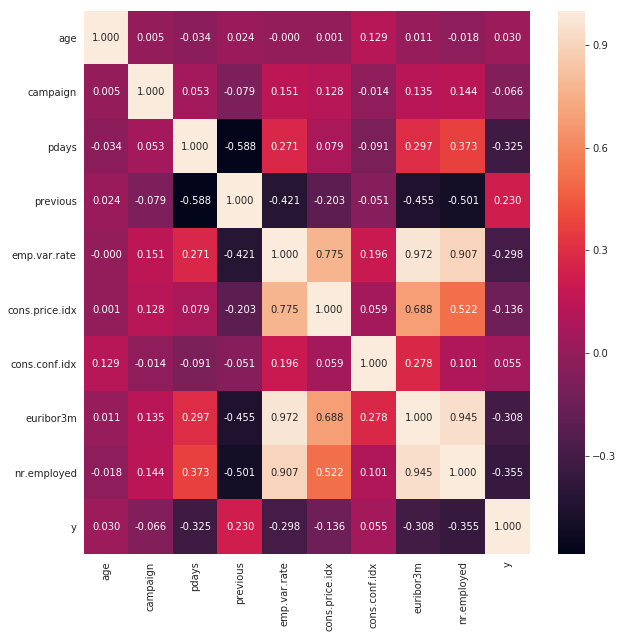

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

bank_data['y'] = le.fit_transform(bank_data.y)
# test = bank_data.pdays.replace(to_replace=999, value=20)
num_bank_data = bank_data[[x for x in bank_data.columns if x not in cat_cols or x =='y']]

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(num_bank_data.corr(), annot=True, fmt='.3f')

In [27]:
[x for x in bank_data.columns]

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

## Establishing a Baseline Outcome

## Hypothesizing Solutions